# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [3]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [4]:
data = pd.read_csv('train.csv')

In [5]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [7]:
train.isna().any() #замечаем пропуски в столбцах keyword и location

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [8]:
test.isna().any() #аналогично

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [9]:
train.fillna(value = '', inplace = True)
test.fillna(value = '', inplace = True)

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [10]:
print((train.target==0).sum(), (train.target==1).sum()) #3024 объекта класса "0"(выдуманных событий) и 2305 объектов класса "1" (настоящих)

3024 2305


2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [12]:
popular_keywords = (train.keyword.value_counts().sort_values(ascending = False))[1:11] #так как самое частое - "", но, видимо, его надо пропустить

In [13]:
popular_keywords

damage               36
siren                35
wreckage             34
fatalities           33
deluge               31
emergency            30
harm                 30
twister              30
nuclear%20reactor    30
fatality             30
Name: keyword, dtype: int64

In [14]:
d = dict(zip(popular_keywords.index, range(10)))
plot_data = train[train.keyword.apply(lambda x: x in popular_keywords)] #выбрали только данные с популярными ключевыми словами
plot_data.sort_values(by = 'keyword', key = lambda x: [d.get(a) for a in x], inplace = True)

<ipython-input-14-4d5f30f4da7c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data.sort_values(by = 'keyword', key = lambda x: [d.get(a) for a in x], inplace = True)


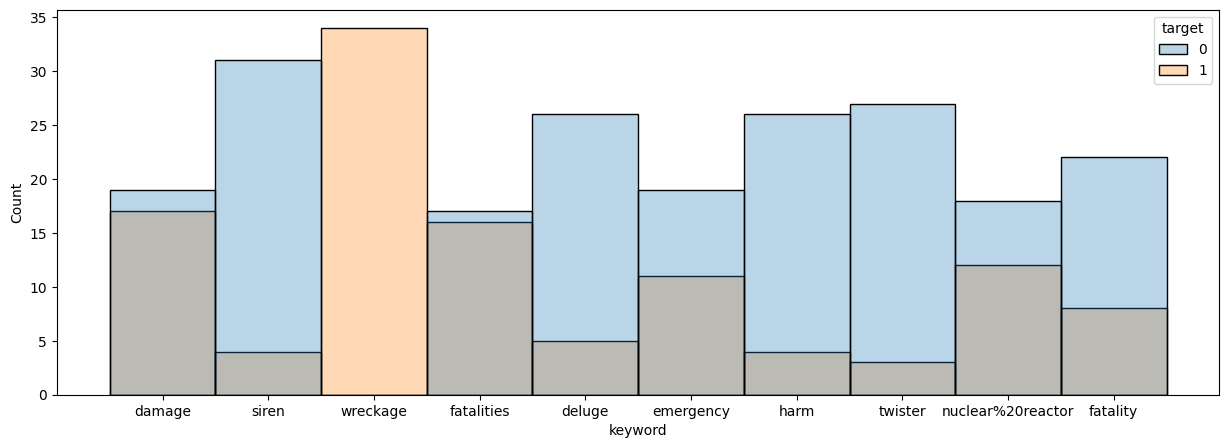

In [15]:
plt.figure(figsize = (15,5))
sns.histplot(plot_data, x='keyword', hue = 'target', alpha = 0.3)
plt.show()

**Выводы**: если новость преимущественно про siren, deluge, emergency, harm, twister, nuclear%20reactor, fatality, то она, скорее всего, неправдива. Если про damage, fatalities - 50/50. Наконец, если про wreckage, то правдива почти наверняка (тут вообще нет ложных новостей, но язык у меня не поворачивается заявить "если новость про wreckage, то точно правдива)


## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [16]:
train.text = train.keyword + ' ' + train.location + ' ' + train.text
train.drop(['id', 'keyword','location'], axis = 1, inplace = True)

## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [17]:
from sklearn.feature_extraction.text import CountVectorizer
y_train = train.target
X_train = train.text
vec = CountVectorizer()
bow = vec.fit_transform(X_train)

In [18]:
bow.shape #размер полученной матрицы

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [19]:
print(vec.vocabulary_)

{'bridge': 2948, '20collapse': 320, 'ashes': 1928, '2015': 295, 'australia': 2059, 'ûªs': 18425, 'collapse': 3914, 'at': 1977, 'trent': 16483, 'among': 1628, 'worst': 17813, 'in': 8314, 'history': 7773, 'england': 5722, 'bundled': 3085, 'out': 11995, 'for': 6503, '60': 755, 'http': 7970, 'co': 3861, 't5trhjuau0': 15733, 'hail': 7420, 'carol': 3363, 'stream': 15419, 'illinois': 8249, 'great': 7206, 'michigan': 10594, 'technique': 15888, 'camp': 3261, 'b1g': 2147, 'thanks': 16013, 'to': 16272, 'bmurph1019': 2753, 'hail_youtsey': 7421, 'termn8r13': 15949, 'goblue': 7088, 'wrestleon': 17848, 'oaskgki6qj': 11648, 'police': 12634, 'houston': 7933, 'cnn': 3854, 'tennessee': 15932, 'movie': 10940, 'theater': 16025, 'shooting': 14647, 'suspect': 15632, 'killed': 9246, 'by': 3150, 'di8elzswnr': 4890, 'rioting': 13800, 'still': 15357, 'couple': 4204, 'of': 11708, 'hours': 7925, 'left': 9644, 'until': 16884, 'have': 7546, 'be': 2383, 'up': 16895, 'class': 3774, 'wounds': 17822, 'lake': 9485, 'high

In [20]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
def contains_digit(s: str) -> bool:
    for i in s:
      if i in '0123456789':
        return True
    return False

def contains_punctuation(s: str) -> bool:
    for i in s:
      if i in punctuation:
        return True
    return False

def is_hashtag(s: str) -> bool:
    return s[0]=='#'

def is_mention(s: str) -> bool:
    return s[0]=='@'

def investigate_vocabulary(vocabulary):
    keys = list(vocabulary.keys())
    contains_digit_var = sum(list(map(contains_digit, keys)))
    contains_punctuation_var = sum(list(map(contains_punctuation, keys)))
    is_hashtag_var = sum(list(map(is_hashtag, keys)))
    is_mention_var = sum(list(map(is_mention, keys)))   
  
    print('With digit:      ', contains_digit_var)
    print('With punctuation:', contains_punctuation_var)
    print('Hashtags:        ', is_hashtag_var)
    print('Mentions:        ', is_mention_var)

In [24]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [25]:
investigate_vocabulary(vec.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


In [26]:
#хэштегов и упоминаний нет. Видимо, дефолтный токейнайзер их уничтожил. Но я вижу, что далее мы будем использовать TweetTokenizer

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [29]:
from nltk.tokenize import TweetTokenizer
tw = TweetTokenizer()

In [30]:
vec = CountVectorizer(tokenizer = tw.tokenize)
vec.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CountVectorizer(tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7ff68ad5f3d0>>)

In [34]:
print(investigate_vocabulary(vec.vocabulary_))  
print('''
Old statistic:
With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0''')

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679
None

Old statistic:
With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


**Сравнение:** Новый токенайзер, в отличие от старого, стал находить хештеги и упоминания. Видимо, старый почти всегда просто избавлялся от этих специальных символов. Стало ГОРАЗДО больше токенов с пунктуацией, немного побольше с цифрами. Теперь можно невооружённым взглядом все эти хештеги и упоминания заметить, посмотрев на словарь. Со старым токенайзером такого не было. Новый мне нравится больше.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [35]:
#!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [37]:
def contains_only_latin_letters(s: str) -> bool:
    for i in s:
      if i not in 'abcdefughijklmnoprstqvwxyz':
        return False
    return True

def is_emoji(s: str) -> bool:
    indicator = False
    for i in s:
      if i not in punctuation:
        return False
      if i in '()':
        indicator = True
    return indicator

def is_hashtag(s: str) -> bool:
    return s[0]=='#' and contains_only_latin_letters(s[1:])

def custom_tokenizer(s: str) -> List[str]:    
    l = tw.tokenize(s.lower())
    l_new = []
    for token in l:
      if (contains_only_latin_letters(token) or is_emoji(token) or is_hashtag(token)) and (token not in nltk.corpus.stopwords.words('english')):
        l_new.append(stemmer.stem(token))
    return l_new

In [38]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [39]:
X_train.head(10).apply(custom_tokenizer)

1186    [bridg, ash, australia, collaps, trent, bridg,...
4071    [hail, carol, stream, illinoi, great, michigan...
5461    [polic, houston, cnn, tennesse, movi, theater,...
5787        [riot, still, riot, coupl, hour, left, class]
7445    [wound, lake, highland, crack, path, wipe, mor...
151     [airplan, somewher, expert, franc, begin, exam...
915     [bloodi, isol, citi, world, perth, came, kill,...
1305                    [burn, except, idk, realli, burn]
2570                  [destroy, (, ask, ), destroy, hous]
7399    [wound, maracay, nirgua, venezuela, polic, off...
Name: text, dtype: object

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [40]:
vectorizer = CountVectorizer(tokenizer = custom_tokenizer)
test.text = test.keyword + ' ' + test.location + ' ' + test.text
test.drop(['id', 'keyword','location'], axis = 1, inplace = True)
y_test = test.target
X_test = test.text
bow_train = vectorizer.fit_transform(X_train)
bow_test = vectorizer.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


2. Обучите LogisticRegression на полученных признаках.


In [41]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(bow_train, y_train)



LogisticRegression()

3. Посчитайте метрику f1-score на тестовых данных.

In [42]:
from sklearn.metrics import f1_score

f1_score(y_test, clf.predict(bow_test))

0.752953813104189

## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer = custom_tokenizer)
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)
clf.fit(tfidf_train, y_train)
f1_score(y_test, clf.predict(tfidf_test))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7422222222222221

1. **Ответ:** Качество немного упало. Я не знаю, как это комментировать, кроме как "значит , мешок слов для данной задачи оказался лучше"

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [45]:
print(tfidf_train.shape, tfidf_test.shape) # то есть раньше токенов было 10482

(5329, 10482) (2284, 10482)


In [46]:
tfidf = TfidfVectorizer(tokenizer = custom_tokenizer, max_df = 0.9)
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)
clf.fit(tfidf_train, y_train)
f1_score(y_test, clf.predict(tfidf_test))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.7422222222222221

In [47]:
print(tfidf_train.shape, tfidf_test.shape) # кол-во не поменялось (качество, соответственно, тоже) Видимо, токенов с df больше 0.9 и не было.
#первая разница замечена лишь при 0.05, какой ужас... и то, всего 2 токена выбыло. Попробовал 0.01 - матрица потеряла уже 127 столбцов. 
#Но начало падать качество... Поэтому, видимо, вообще трогать этот параметр не стоит


(5329, 10482) (2284, 10482)


In [50]:
tfidf = TfidfVectorizer(tokenizer = custom_tokenizer, max_df = 0.01)
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)
clf.fit(tfidf_train, y_train)
f1_score(y_test, clf.predict(tfidf_test))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.6899360093077371

In [51]:
print(tfidf_train.shape, tfidf_test.shape)

(5329, 10355) (2284, 10355)




2. **Ответ:** Видимо, сверху тут лучше ничего не ограничивать

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [52]:
tfidf = TfidfVectorizer(tokenizer = custom_tokenizer, min_df = 0.001)
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)
clf.fit(tfidf_train, y_train)
print('F1 score:', f1_score(y_test, clf.predict(tfidf_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7449259462424574


3. **Ответ:** Опаньки. А вот тут качество немного подросло(в смысле использования tfidf векторайзера. То есть убрать из рассмотрения самые редкие токены оказалось полезным.

## Задание 10 (1 балл)

Еще один популярный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [53]:
from sklearn.feature_extraction.text import HashingVectorizer
#сделаю дважды: с нашим токенайзером и без него
#без:
vec = HashingVectorizer(n_features = 5000)
hash_train = vec.fit_transform(X_train)
hash_test = vec.transform(X_test)
clf.fit(hash_train, y_train)
print('F1 score(without custom_tokenizer):', f1_score(y_test, clf.predict(hash_test)))
#и с:
vec = HashingVectorizer(tokenizer = custom_tokenizer, n_features = 5000)
hash_train = vec.fit_transform(X_train)
hash_test = vec.transform(X_test)
clf.fit(hash_train, y_train)
print('F1 score(with custom_tokenizer):', f1_score(y_test, clf.predict(hash_test)))

F1 score(without custom_tokenizer): 0.7253481894150418


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score(with custom_tokenizer): 0.7190635451505016


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** самые высокие результаты показали:
1 место: просто bag of words, с нашим самодельным токенизатором
2 место: tlidf vectorizer, в котором был ограничен минимум по словам, с нашим самодельным токенизатором
Вывод: иногда Bag of words оказывается лучше

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [54]:
vec = CountVectorizer(tokenizer = custom_tokenizer)
bow_train = vec.fit_transform(X_train)
bow_test = vec.transform(X_test)
clf.fit(bow_train, y_train)
f1_score(y_test, clf.predict(bow_test))
#ну, такой у нас уже был. Я для приличия ещё поигрался с параметрами(даже словил ошибку, что при данных min_df
#и max_df токенов не осталось, хах), но улучшить не получилось. Вроде как мера 0.75 достигнута, задание выполнено

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


0.752953813104189